In [29]:
from __future__ import absolute_import, division, print_function
from sklearn.model_selection import train_test_split
from tools import ShowProcess
from math import sqrt
import time
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import keras

map_beijing = pickle.load(open('map_beijing_small.pkl', 'rb'))    # 220 * 170 * 1440
map_shanghai = pickle.load(open('map_shanghai_small.pkl', 'rb'))  # 122 * 136 * 4464

lon_beijing, lat_beijing, time_beijing = map_beijing.shape
lon_shanghai, lat_shanghai, time_shanghai = map_shanghai.shape
lon_max = max([lon_beijing, lon_shanghai])
lat_max = max([lat_beijing, lat_shanghai])
lon_pad_beijing = int((lon_max - lon_beijing) / 2)
lat_pad_beijing = int((lat_max - lat_beijing) / 2)
lon_pad_shanghai = int((lon_max - lon_shanghai) / 2)
lat_pad_shanghai = int((lat_max - lat_shanghai) / 2)

days = 1
period = days * 2 * 24   # 0.5h
block_num_beijing = int((map_beijing.shape[2] - period)*6/30)    # number of training blocks 1month
block_num_shanghai = int(map_shanghai.shape[2] - period)     # number of training blocks 3month
data_b = np.zeros([block_num_beijing, lon_max, lat_max, period])
data_s = np.zeros([block_num_shanghai, lon_max, lat_max, period])
predict_label_b = np.zeros([block_num_beijing, lon_max, lat_max, 1])
predict_label_s = np.zeros([block_num_shanghai, lon_max, lat_max, 1])
domain_label_b = np.zeros([block_num_beijing, 1])
domain_label_s = np.zeros([block_num_shanghai, 1])

for i in range(block_num_beijing):
    temp = map_beijing[:, :, i:i+period+1]
    temp = np.pad(temp, ((lon_pad_beijing, lon_pad_beijing),(lat_pad_beijing, lat_pad_beijing),(0,0)), 'constant')
    data_b[i] = temp[:, :, 0:period]
    predict_label_b[i] = temp[:, :, period].reshape(lon_max, lat_max, 1)
    domain_label_b[i] = 0

train_data_b, test_data, train_predict_label_b, test_predict_label, train_domain_label_b, test_domain_label = train_test_split(
    data_b, predict_label_b, domain_label_b, test_size=0.5, random_state=7)


for i in range(block_num_shanghai):
    temp = map_shanghai[:, :, i:i+period+1]
    temp = np.pad(temp, ((lon_pad_shanghai, lon_pad_shanghai),(lat_pad_shanghai, lat_pad_shanghai),(0,0)), 'constant')
    data_s[i] = temp[:, :, 0:period]
    predict_label_s[i] = temp[:, :, period].reshape(lon_max, lat_max, 1)
    domain_label_s[i] = 1

index = np.arange(len(train_data_b)+len(data_s))
np.random.shuffle(index)

train_data = np.concatenate((train_data_b, data_s), axis=0)
train_data = train_data[index]
train_predict_label = np.concatenate((train_predict_label_b, predict_label_s), axis=0)
train_predict_label = train_predict_label[index]
train_domain_label = np.concatenate((train_domain_label_b, domain_label_s), axis=0)
train_domain_label = train_domain_label[index]

print('========== finished loading ==========')

train_num = train_data.shape[0]
test_num = test_data.shape[0]
print('train_data',train_data.shape)
print('test_data',test_data.shape)
print('train_predict_label',train_predict_label.shape)
print('test_predict_label',test_predict_label.shape)
print('train_domain_label',train_domain_label.shape)
print('test_domain_label',test_domain_label.shape)


========== finished loading ==========
train_data (4555, 50, 50, 48)
test_data (139, 50, 50, 48)
train_predict_label (4555, 50, 50, 1)
test_predict_label (139, 50, 50, 1)
train_domain_label (4555, 1)
test_domain_label (139, 1)


In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

class TransferNet:
    @staticmethod
    def build_FeatureNet(inputs):
        x = keras.layers.ConvLSTM2D(3, kernel_size=3, activation=tf.nn.relu, padding = "same")(inputs)
        #3, kernel_size=3, padding = "same", batch_input_shape=(1, None, 2*WINDOW_H+1, 2*WINDOW_W+1, 1), return_sequences=True, stateful=True))
        #x = keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding="same")(x)
        #x = keras.layers.TimeDistributed(keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding="same"))(X)
        #x = keras.layers.Dropout(0.2)(x)
        return x
    
    @staticmethod
    def build_PredictNet(inputs):
        #x = keras.layers.Dropout(0.2)(inputs)
        x = keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding="same")(inputs)
        x = keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding="same")(x)
        x = keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding="same")(x)
        #x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu, padding="same")(x)
        x = keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu, padding="same")(x)
        x = keras.layers.Dense(1, name="predict_output")(x)
        return x

    @staticmethod
    def build_DomainNet(inputs):
        x = keras.layers.Dense(1, activation=tf.nn.relu)(inputs)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1, activation=tf.nn.sigmoid, name="domain_output")(x)
        return x
    
    @staticmethod
    def build(lon, lat, period):
        inputs = keras.layers.Input(shape=(None, lon, lat, period))
        region_representation = TransferNet.build_FeatureNet(inputs)
        predict_branch = TransferNet.build_PredictNet(region_representation)
        domain_branch = TransferNet.build_DomainNet(region_representation)
        model = keras.models.Model(inputs=inputs, outputs=[predict_branch, domain_branch])
        return model

model = TransferNet.build(lon_max, lat_max, period)
losses = {
    "predict_output": "mse",
    "domain_output": "binary_crossentropy"
}
loss_weights = {
    "predict_output": 1.0,
    "domain_output": -0.001
}
optimizer = tf.train.AdamOptimizer(0.001)
model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics=["accuracy"])
model.summary()

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

TypeError: while_loop() got an unexpected keyword argument 'maximum_iterations'

In [49]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        process_bar.show_process()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
process_bar = ShowProcess(EPOCHS, '')
history = model.fit(train_data,
                    {"predict_output": train_predict_label.reshape([train_num, lon_max, lat_max, 1]),
                     "domain_output": train_domain_label},
                    epochs=EPOCHS,
                    validation_split=0.2, verbose=1,
                    batch_size=24,
                    callbacks=[])

results = model.evaluate(test_data,
                     {"predict_output": test_predict_label.reshape([test_num, lon_max, lat_max, 1]),
                      "domain_output": test_domain_label},
                      verbose=0)
#print(results)
predict_mse = results[1]
domain_mse = results[2]
#print(model.metrics_names)
rmse = sqrt(predict_mse)
print("Testing set Root Mean Squared Error: {:1.3f}".format(rmse))
print("Domain loss", domain_mse)

Train on 3644 samples, validate on 911 samples
Epoch 1/10
 192/3644 [>.............................] - ETA: 3:14 - loss: nan - predict_output_loss: nan - domain_output_loss: nan - predict_output_acc: 0.0000e+00 - domain_output_acc: 0.0000e+00

KeyboardInterrupt: 

In [28]:

a=model.predict(test_data[0:4])
a

[array([[[[ 4.17024517e+00],
          [ 2.63460297e+02],
          [ 1.83098358e+02],
          ...,
          [-2.40152627e-01],
          [-2.40152627e-01],
          [-2.40152627e-01]],
 
         [[ 2.29156509e+02],
          [ 1.21529590e+03],
          [ 9.76440369e+02],
          ...,
          [-2.40152627e-01],
          [-2.40152627e-01],
          [-2.40152627e-01]],
 
         [[ 4.97108002e+01],
          [-2.39783108e-01],
          [-2.39783108e-01],
          ...,
          [-2.40152627e-01],
          [-2.40152627e-01],
          [-2.40152627e-01]],
 
         ...,
 
         [[-2.39783108e-01],
          [-2.39783108e-01],
          [-2.39561409e-01],
          ...,
          [-2.39783108e-01],
          [-2.39783108e-01],
          [-2.40152627e-01]],
 
         [[ 8.32830966e-01],
          [-2.38222122e-01],
          [-1.16441123e-01],
          ...,
          [ 2.33159304e-01],
          [-2.39783108e-01],
          [-2.39783108e-01]],
 
         [[-2.39783108e-

In [20]:
#print(results)
predict_mse = results[1]
domain_mse = results[2]
#print(model.metrics_names)
rmse = sqrt(predict_mse)
print("Testing set Root Mean Squared Error: {:1.3f}".format(rmse))
print("Domain MSE", domain_mse)

Testing set Root Mean Squared Error: 28.098
Domain MSE 15.942383917115576


In [28]:
from __future__ import absolute_import, division, print_function
from tools import ShowProcess
from math import sqrt
import tensorflow as tf
import numpy as np
import pickle as cPickle
import keras
from sklearn.model_selection import train_test_split

map_beijing = cPickle.load(open('map_beijing_small.pkl', 'rb'))   # 220 * 170 * 1440
#map_shanghai = cPickle.load(open('map_shanghai.pkl', 'rb'))

days = 1
period = int(days * 2 * 24)   # 0.5h
block_num = int((map_beijing.shape[2] - period)*6/30)    # number of training blocks
data = []
label = []
for i in range(block_num):
    data.append(map_beijing[:, :, i:i+period])
    label.append(map_beijing[:, :, i+period])

data = np.array(data)
label = np.array(label)
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.5, random_state=7)
#train_data = train_data[0:int(len(train_data)/8)]
#train_label = train_label[0:int(len(train_label)/8)]
train_num = train_data.shape[0]
test_num = test_data.shape[0]
print('train_data',train_data.shape)
print('train_label',train_label.shape)
print('test_data',test_data.shape)
print('test_label',test_label.shape)

def build_model():
  model = keras.models.Sequential([
      keras.layers.ConvLSTM2D(4, (3,3), activation=tf.nn.relu, padding="same", input_shape=train_data.shape[0:]),
      keras.layers.ConvLSTM2D(4, (3,3), activation=tf.nn.relu, padding="same"),
      #keras.layers.Dropout(0.2),
      keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding="same"),
      keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding="same"),
      #keras.layers.Dropout(0.2),
      keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, padding="same"),
      keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, padding="same"),
      keras.layers.Conv2D(1, (1,1))
  ])

  optimizer = tf.train.AdamOptimizer(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

model = build_model()
model.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        process_bar.show_process()

EPOCHS = 200
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
process_bar = ShowProcess(EPOCHS, '')
history = model.fit(train_data, train_label.reshape([train_num, 50, 50, 1]), epochs=EPOCHS,
                    validation_split=0.2, verbose=1, batch_size=64,
                    callbacks=[])

#print('history.history: ',history.history)
#file_his = open('history_simple_'+str(days)+'d.txt','a')
#file_his.write(str(history.history))
#file_his.close()
results = model.evaluate(test_data, test_label.reshape([test_num, 50, 50, 1]), verbose=1)
print(results)
print(model.metrics_names)
rmse = sqrt(results[0])
print("Testing set Root Mean Squared Error: {:1.3f}".format(rmse))

train_data (139, 50, 50, 48)
train_label (139, 50, 50)
test_data (139, 50, 50, 48)
test_label (139, 50, 50)


TypeError: while_loop() got an unexpected keyword argument 'maximum_iterations'

In [86]:
import numpy as np
import _pickle as cPickle
import json

map_beijing = np.zeros([288, 1, 50, 50])
with open("population_tencent_beijing_2000w.json", 'r') as file_beijing:
    load_dict = json.load(file_beijing)
loc = load_dict['centers']['count']
pop = load_dict['population']['count']
popin = load_dict['population']['in']
popout = load_dict['population']['out']
for i in range(len(loc)):
    lon = loc[i][0]
    lat = loc[i][1]
    lon = int(lon * 100) - 11655
    lat = int(lat * 100) - 4000
    if 0 <= lon < 50 and 0 <= lat < 50:
        map_beijing[:,0,lat,lon] += pop[i][:288]
        #map_beijing[:,1,lat,lon] += popout[i][:288]

In [87]:
import h5py
f = h5py.File('NYC14_M16x8_T60_NewEnd.h5','r')
_, date=f.keys()
t = f[date][0:288]
f.close()
h5file = h5py.File('map_beijing_count.h5','w')
#X = h5file.create_dataset(shape=(1440,2,50,50), dtype=float, compression='gzip', name='data')
h5file.create_dataset('data', data = map_beijing)
h5file.create_dataset('date', data = t)
h5file.close()

In [88]:
f = h5py.File('map_beijing_count.h5','r')
for key in f.keys():
    print(f[key].name)
    print(f[key].shape)
    print(f[key].value)

/data
(288, 1, 50, 50)
[[[[2.700e+01 1.200e+02 4.630e+02 ... 0.000e+00 0.000e+00 0.000e+00]
   [1.840e+02 5.230e+02 4.320e+02 ... 0.000e+00 0.000e+00 0.000e+00]
   [3.000e+00 0.000e+00 2.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
   ...
   [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]]


 [[[3.300e+01 1.390e+02 5.370e+02 ... 0.000e+00 0.000e+00 0.000e+00]
   [2.220e+02 6.050e+02 5.200e+02 ... 0.000e+00 0.000e+00 0.000e+00]
   [4.000e+00 0.000e+00 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
   ...
   [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]]


 [[[3.900e+01 1.570e+02 5.850e+02 ... 0.000e+00 0.000e+00 0.000e+00]
   [2.450e+02 6.650e+02 5.270e+02 ... 0.000e+00 0.000e+00 

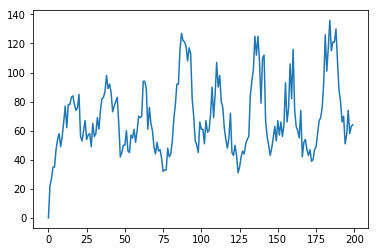

In [42]:
import matplotlib.pyplot as plt
plt.plot(popin[0][0:200])
plt.show()

In [82]:
np.array(popin[0][0:288]).shape

(288,)